In [2]:
import tensorflow as tf
from skimage.io import imread_collection
from sklearn.model_selection import train_test_split
from glob import glob
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
def load_and_augment():
    images = np.asarray(imread_collection(sorted(glob('dida_test_task/images/*.png'))[:-5], plugin='matplotlib'))
    labels = np.asarray(imread_collection(sorted(glob('dida_test_task/labels/*.png')), plugin='matplotlib'))
    
    images_flipped_horizontal = images[:,::-1,:,:]
    labels_flipped_horizontal = labels[:,::-1,:]
    images_flipped_vertical = images[:,:,::-1,:]
    labels_flipped_vertical = labels[:,:,::-1]
    images_flipped_both = images[:,::-1,::-1,:]
    labels_flipped_both = labels[:,::-1,::-1]
    
    images_all = np.append(images, images_flipped_horizontal, axis=0)
    images_all = np.append(images_all, images_flipped_vertical, axis=0)
    images_all = np.append(images_all, images_flipped_both, axis=0)
    
    display(images_all.shape)
    
    labels_all = np.append(labels, labels_flipped_horizontal, axis=0)
    labels_all = np.append(labels_all, labels_flipped_vertical, axis=0)
    labels_all = np.append(labels_all, labels_flipped_both, axis=0)
    
    display(labels_all.shape)
    
    return train_test_split(np.array(images), labels, test_size=0.2)

images_train, images_val, labels_train, labels_val = load_and_augment()
    

(100, 256, 256, 4)

(100, 256, 256)

In [4]:
input = tf.keras.Input(shape=(256, 256, 4))
f1 = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(input)
f1 = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(f1)
f1 = tf.keras.layers.MaxPooling2D(2)(f1) # 256 -> 128

f2 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(f1)
f2 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(f2)
f2 = tf.keras.layers.MaxPooling2D(2)(f2) # 128 -> 64

f3 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(f2)
f3 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(f3)
f3 = tf.keras.layers.MaxPooling2D(2)(f3) # 64 -> 32

m = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(f3)
m = tf.keras.layers.MaxPooling2D(2)(m) # 32 -> 16

# 16 -> 32
b1 = tf.keras.layers.Conv2DTranspose(128, 3, padding='same', strides=2, activation='relu')(m)
b1 = tf.keras.layers.Concatenate()([b1, f3])

# 32 -> 64
b2 = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(b1)
b2 = tf.keras.layers.Concatenate()([b2, f2])

# 64 -> 128
b3 = tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(b2)
b3 = tf.keras.layers.Concatenate()([b3, f1])

# 128 -> 256
b4 = tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding='same', activation='sigmoid')(b3)

model = tf.keras.Model(input, b4)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  1184        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [5]:
model.compile(optimizer='adam', loss='binary_crossentropy')

In [6]:
callbacks = [tf.keras.callbacks.ModelCheckpoint("roof_detection.h5", save_best_only=True),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=15, 
                                              restore_best_weights=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.5,
                                                  patience = 10,
                                                  min_lr=10**-7),
             ]

model.fit(x=images_train.reshape((-1, 256, 256, 4)), 
          y=labels_train.reshape((-1, 256, 256, 1)), 
          validation_data=(images_val.reshape((-1,256,256,4)), labels_val.reshape(-1,256,256,1)), 
          callbacks=callbacks,
          epochs=500,
          batch_size=10)

Epoch 1/500
2/2 [==============================] - 11s 2s/step - loss: 0.6932 - val_loss: 0.6767 - lr: 0.0010
Epoch 2/500
2/2 [==============================] - 0s 247ms/step - loss: 0.6665 - val_loss: 0.6360 - lr: 0.0010
Epoch 3/500
2/2 [==============================] - 0s 252ms/step - loss: 0.6032 - val_loss: 0.5894 - lr: 0.0010
Epoch 4/500
2/2 [==============================] - 0s 257ms/step - loss: 0.5350 - val_loss: 0.5661 - lr: 0.0010
Epoch 5/500
2/2 [==============================] - 0s 251ms/step - loss: 0.4970 - val_loss: 0.5208 - lr: 0.0010
Epoch 6/500
2/2 [==============================] - 0s 252ms/step - loss: 0.4682 - val_loss: 0.5178 - lr: 0.0010
Epoch 7/500
2/2 [==============================] - 0s 259ms/step - loss: 0.4496 - val_loss: 0.4997 - lr: 0.0010
Epoch 8/500
2/2 [==============================] - 0s 260ms/step - loss: 0.4381 - val_loss: 0.4860 - lr: 0.0010
Epoch 9/500
2/2 [==============================] - 0s 249ms/step - loss: 0.4353 - val_loss: 0.4791 - lr: 0

2/2 [==============================] - 0s 185ms/step - loss: 0.2526 - val_loss: 0.3448 - lr: 0.0010
Epoch 74/500
2/2 [==============================] - 0s 184ms/step - loss: 0.2475 - val_loss: 0.3338 - lr: 0.0010
Epoch 75/500
2/2 [==============================] - 0s 186ms/step - loss: 0.2414 - val_loss: 0.3441 - lr: 0.0010
Epoch 76/500
2/2 [==============================] - 0s 186ms/step - loss: 0.2396 - val_loss: 0.3784 - lr: 5.0000e-04
Epoch 77/500
2/2 [==============================] - 0s 184ms/step - loss: 0.2609 - val_loss: 0.3685 - lr: 5.0000e-04
Epoch 78/500
2/2 [==============================] - 0s 185ms/step - loss: 0.2661 - val_loss: 0.3284 - lr: 5.0000e-04
Epoch 79/500
2/2 [==============================] - 0s 261ms/step - loss: 0.2630 - val_loss: 0.3039 - lr: 5.0000e-04
Epoch 80/500
2/2 [==============================] - 0s 183ms/step - loss: 0.2590 - val_loss: 0.3412 - lr: 5.0000e-04
Epoch 81/500
2/2 [==============================] - 0s 184ms/step - loss: 0.2499 - val_lo

1/1 [==============================] - 0s 356ms/step


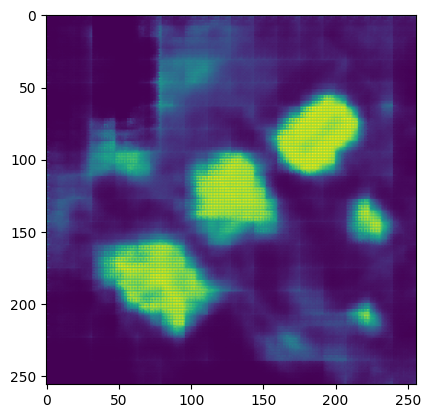

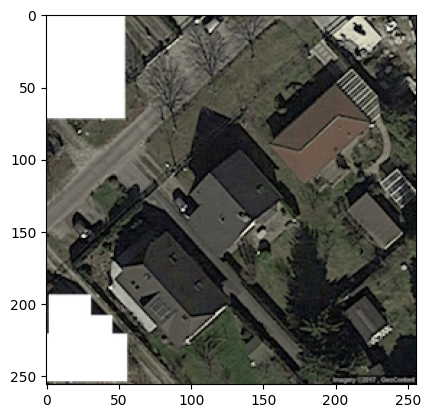

In [7]:
test_images = np.asarray(imread_collection(sorted(glob('dida_test_task/images/*.png'))[-5:], plugin='matplotlib'))
predictions = model.predict(test_images)
prediction = predictions[4].reshape((256,256))
plt.imshow(prediction*255.0)
plt.show()
plt.imshow(test_images[4])

In [8]:
def compute_IoU(predictions, labels, threshold):
    iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])
    labels_binary = np.zeros_like(labels)
    labels_binary[np.where(labels>0)] = 1
    mask = np.zeros_like(predictions)
    mask[np.where(predictions>threshold)] = 1
    # iou.update_state(mask, labels_binary)
    # return iou.result().numpy()
    intersection = np.sum(labels_binary * mask)
    union = np.sum(labels_binary) + np.sum(mask) - np.sum(labels_binary * mask)
    return intersection / union
    

def find_optimal_threshold(predictions, labels):
    """
    find optimal threshold between 0 and 255.
    """
    max_key = 0
    max_value = 0
    for threshold in np.arange(0, 1, 0.05):
        iou_current = compute_IoU(predictions, labels, threshold)
        if iou_current > max_value:
            max_key = threshold
            max_value = iou_current
    return max_key, max_value 

In [9]:
images = np.append(images_train, images_val, axis=0)

labels = np.append(labels_train, labels_val, axis=0)

predictions = model.predict(images).reshape((25, 256, 256))

optimal_threshold, iou = find_optimal_threshold(predictions, labels)

1/1 [==============================] - 4s 4s/step


0.0

0.16617188

0.05

0.31860152

0.1

0.39378724

0.15000000000000002

0.4535467

0.2

0.49364194

0.25

0.5106004

0.30000000000000004

0.5099611

0.35000000000000003

0.49537453

0.4

0.46015507

0.45

0.3712979

0.5

0.14467376

0.55

0.027191307

0.6000000000000001

6.611352e-05

0.65

1.8365068e-05

0.7000000000000001

0.0

0.75

0.0

0.8

0.0

0.8500000000000001

0.0

0.9

0.0

0.9500000000000001

0.0

(0.25, 0.5106004)

1/1 [==============================] - 0s 24ms/step


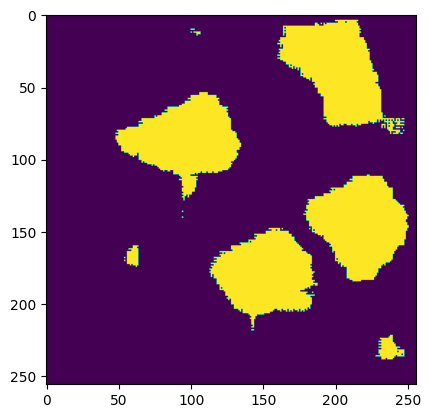

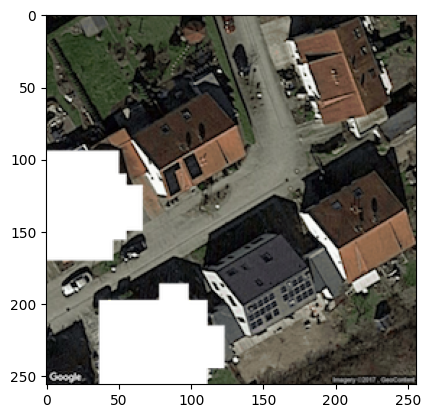

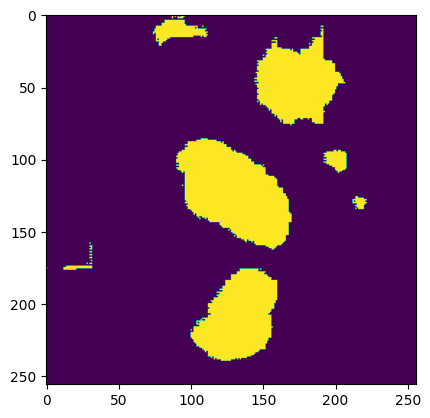

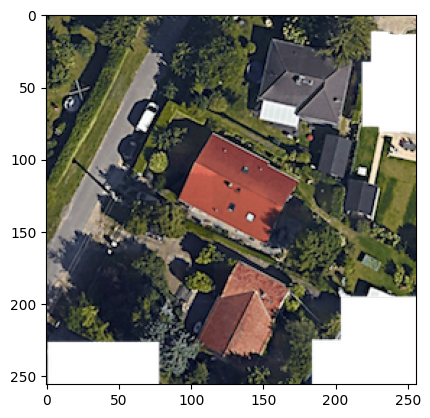

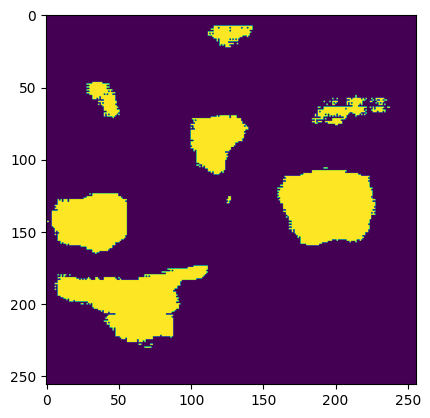

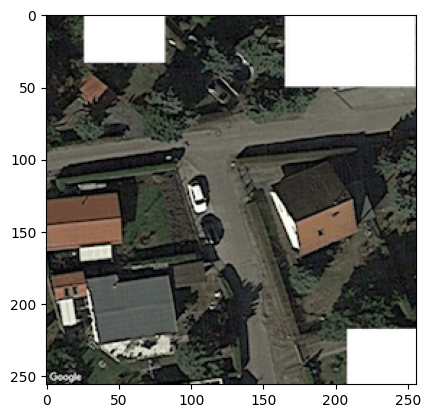

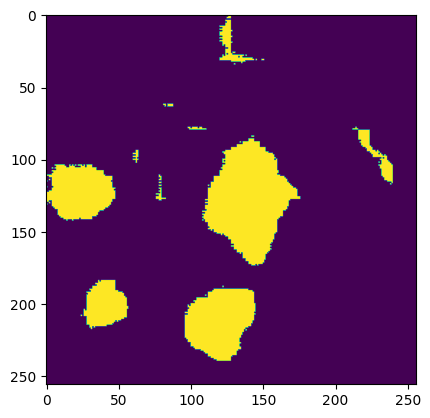

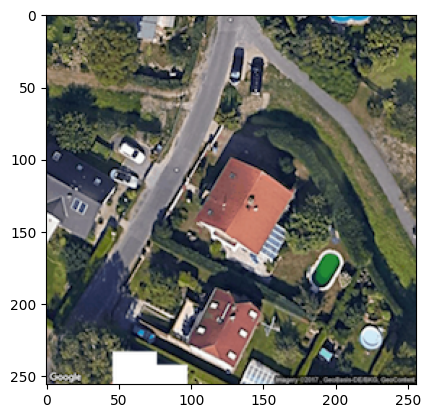

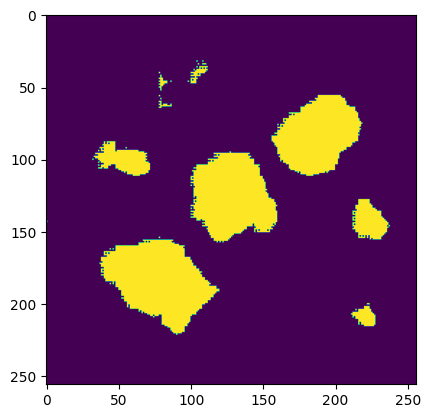

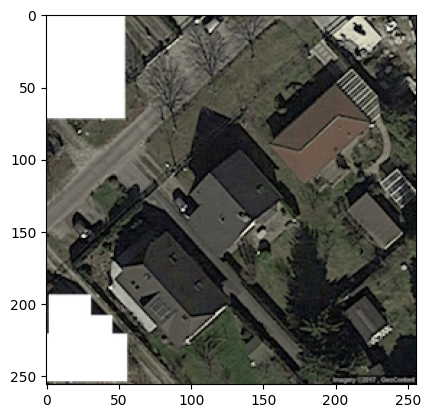

In [16]:
test_images = np.asarray(imread_collection(sorted(glob('dida_test_task/images/*.png'))[-5:], plugin='matplotlib'))
predictions = model.predict(test_images)
for idx, prediction in enumerate(predictions):
    prediction_binary = np.zeros_like(prediction)
    prediction_binary[np.where(prediction>0.25)] = 1
    plt.imshow(prediction_binary)
    plt.imsave(f'dida_test_task/test_results/{idx}.png', prediction_binary.reshape((256,256)))
    plt.show()
    plt.imshow(test_images[idx])
    plt.show()

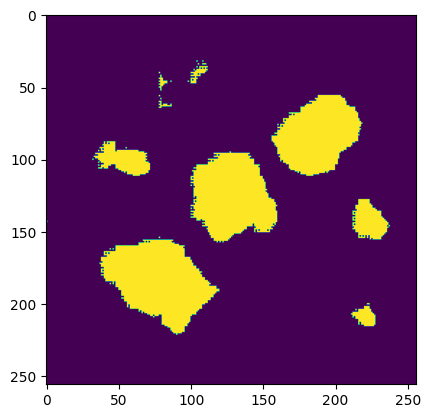

In [10]:
prediction_binary = np.zeros_like(prediction)
prediction_binary[np.where(prediction>0.25)] = 1
plt.imshow(prediction_binary)

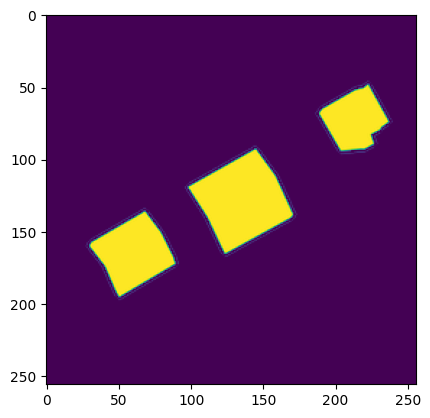

In [10]:
plt.imshow(labels_train[0])